In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

import warnings
warnings.filterwarnings('ignore')

In [2]:
n = 10
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(1, 7)
radius = 1 

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[-1.65871978e-02-5.3670728e-03j -1.39763383e-02-6.3194972e-03j
   9.84836370e-04-2.4789704e-03j  1.29268905e-02+6.2423362e-03j
   7.15205383e+01+4.5895561e+01j  1.34298643e-02-1.1327449e-03j
  -2.67283935e-02-8.6815292e-03j  1.16867032e-02+1.1286285e-02j
   4.01170691e-03-5.1386185e-05j  1.71391177e-03-1.4526373e-03j]
 [-1.64790098e-02-7.2107208e-04j -1.27633791e-02-1.2077794e-02j
   6.32798346e-03-6.3146306e-03j  2.82264454e-03+2.0833220e-02j
   1.25727551e-02+5.8830930e-03j  1.52743077e-02-1.1642481e-03j
   9.40422155e-03-1.0110108e-03j  6.06369646e-03-3.7933132e-03j
   8.32406897e-03+1.1722323e-02j -1.16765767e-03-3.2945399e-03j]
 [-2.90978421e-03-1.0391578e-02j  1.30965486e-02-5.7011982e-04j
  -1.19749662e-02-1.1015530e-02j -4.01866331e-04-6.2020533e-03j
   4.45790729e-03-2.0586378e-03j -8.20688438e-03+3.6809433e-03j
   3.10484646e-03-8.5373493e-03j -5.13551617e-03-1.2839726e-03j
  -1.63889732e-02-7.4979477e-03j -8.76325648e-03-1.2569056e-02j]
 [-2.78850482e-03+6.7078699e-03j -9.2

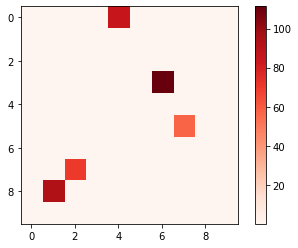

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds')
plt.colorbar();

In [4]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 312.05185  +258.33682j    -69.19449  -107.391j
   122.44206  -123.38152j     63.232212  +19.962698j
  -153.84808   -83.550865j   138.86925   +12.3089075j
  -136.65385  -179.81491j    -65.48868   +56.426086j
  -143.93295  +128.41263j    -67.96598   +18.548855j ]
 [  -7.188242  +28.308268j   101.44924  +165.675j
     9.744915 +117.773994j   212.28589  -117.06801j
  -119.481224  -28.805977j   152.0592    -27.85907j
   -19.37034    +1.7990372j  -93.82498  -142.17322j
   136.39288  -119.074165j  -372.2532   +121.41662j  ]
 [-145.0214     +9.865468j  -147.01527   -71.18953j
  -104.122665 +277.51404j    161.16202   -25.100103j
    60.422966 +132.17511j    -21.30776   -40.415894j
   140.47713  -159.55643j    -14.1356945+235.38211j
    48.17587  -259.65228j     21.156937  -98.59068j  ]
 [ 133.71521   -14.083575j  -122.02836  -303.8649j
   -74.67554  +101.27115j   -206.6484    +74.16843j
   -14.057735   -7.874894j   198.56721  +272.58673j
  -117.88221  -135.34451j    118.64279   +36.79165j
  

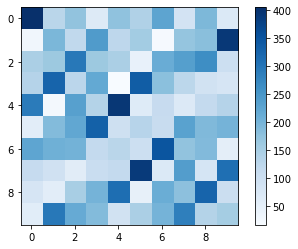

In [5]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

In [6]:
sanity = np.fft.ifft2(visibilities).astype('complex64')

test1_real = ((sky_image.real - sanity.real)**2).mean()
test1_imag = ((sky_image.imag - sanity.imag)**2).mean()
 
print('Reals MSE: '+ str(test1_real))
print('Imaginaries MSE: '+ str(test1_imag))

Reals MSE: 9.066061e-14
Imaginaries MSE: 1.5071546e-13


In [7]:
print( 'Encodes log2(n) qubits: ' + str(math.log2(n*n)) )

Encodes log2(n) qubits: 6.643856189774724


Wires: range(0, 7)
100
128


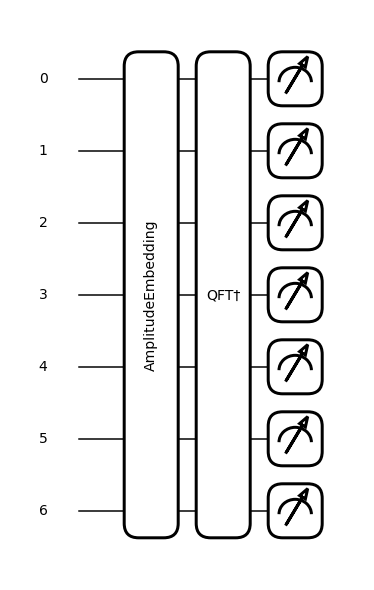

In [8]:
n_n = visibilities.shape[0]*visibilities.shape[1]
inp = visibilities.flatten()

norm = qml.math.sum(qml.math.abs(inp) ** 2)
#normalized_data = data / qml.math.sqrt(norm)

wires = range(math.ceil(math.log2(n_n)))
print( 'Wires: ' + str(wires) )
amp_dev = qml.device('default.qubit', wires)


@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires, normalize=True, pad_with=0.)
    qml.adjoint(qml.QFT)(wires=wires)
    return qml.state()

readout = amp_encoding(inp).astype('complex64')
qml.draw_mpl(amp_encoding)(inp)

print(len(inp))
print(len(readout))

readout.numpy()
readout = readout[:100]
readout = readout*qml.math.sqrt(norm)
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])

In [9]:
fidelity = readout
#fidelity = np.fft.ifft2(readout).astype('complex64')

test2_real = ((sky_image.real - fidelity.real)**2).mean()
test2_imag = ((sky_image.imag - fidelity.imag)**2).mean()

print('Reals MSE: '+ str(test2_real))
print('Imaginaries MSE: '+ str(test2_imag))

Reals MSE: 16693.457
Imaginaries MSE: 7654.477


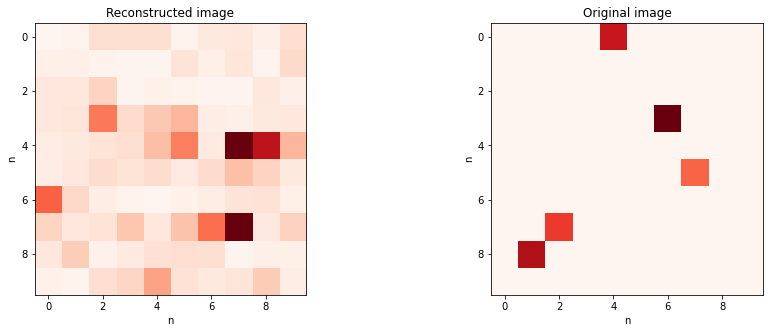

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(fidelity)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')